# Capstone Project - The Battle of the Neighborhoods (Final Step)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we are going to choose a suitable place in **San Francisco** to open a **Japanese restaurant**. Our employer has requested that a suitable location for him be in a **safe area** and in a **safe neighborhood** where there are **few Japanese or East Asian restaurants**.

Therefore, we would like to focus on these features. 
We will introduce him to **the safest area, and in area, the 3 safest neighborhoods** that have few Japanese or Asian restaurants.

## Data <a name="data"></a>

Because we want to identify the safest areas and the safest neighborhoods. We need data crime and neighborhood division data in San Francisco, which we downloaded from the <a href="https://data.sfgov.org/">here</a>.
<a href="https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783">Crime Dataset</a> <a href="https://data.sfgov.org/Geographic-Locations-and-Boundaries/Realtor-Neighborhoods/5gzd-g9ns/data">Neighborhood Area</a>
 

Also number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API

### Import important lib's

In [3]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim 

import geopandas as gpd
import shapely
from shapely.geometry import Point

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from IPython.display import display

import requests
import json 

from sklearn.cluster import KMeans

import pysal as ps

import folium 

print('Libraries imported.')

Libraries imported.


#### Create some useful functions and variable.

In [4]:
# It takes the address and returns its geographical location
def get_coordinate(address):

    non = Nominatim(user_agent="ny_explorer")
    location = non.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} US are {}, {}.'.format(address, latitude, longitude))
    return latitude, longitude

In [5]:
# Get geographical location of San Francisco.
get_coordinate('San Francisco, US')

The geograpical coordinate of San Francisco, US US are 37.7790262, -122.4199061.


(37.7790262, -122.4199061)

geojson files used in this project.

In [6]:
san_francisco_police_district_geo = r"Current Police Districts.geojson"
san_francisco_neighborhood_gep = r"Realtor Neighborhoods.geojson"

Create map with marker.

In [7]:
def plot_geo_map_marker(geo_location_list,
                        geo_json_file, 
                        df_for_chloropleth,
                        df_columns_for_chloropleth,
                        geo_json_key_on,
                        marker_la,
                        marker_lo,
                        marker_label_one,
                        marker_label_two,
                        th_scale=None,
                        go_zoom_start=12, 
                        go_width="100%", 
                        go_height="100%"):
    
    
    sanfran_geo_map = folium.Map(location=geo_location_list, zoom_start=go_zoom_start, width=go_width, height=go_height)
    
    # add chloropleth layer
    sanfran_geo_map.choropleth(
            geo_data=geo_json_file,
            data=df_for_chloropleth,
            columns=df_columns_for_chloropleth,
            key_on=geo_json_key_on,
            fill_color='YlOrRd',
            threshold_scale = th_scale,
            fill_opacity=0.7, 
            line_opacity=0.2)

    # create marker 
    sanfrancisco = folium.map.FeatureGroup()
    
    for la, ln, label_one, label_two in zip(marker_la, marker_lo, marker_label_one, marker_label_two):
            folium.features.CircleMarker(
                [la, ln],
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                popup=label_one + " - " +str(label_two),
                fill_color='blue',
                fill_opacity=0.6,
                ).add_to(sanfran_geo_map)
    
    
    
    
    return sanfran_geo_map

print("Done")

Done


In [118]:
# plot three commone venue in cluster
def plot_number_of_venue(df_cluster):

    cluster_first = df_cluster["1st Most Common Venue"].value_counts()
    cluster_second = df_cluster["2nd Most Common Venue"].value_counts()
    cluster_third = df_cluster["3rd Most Common Venue"].value_counts()

    a = cluster_first.index.tolist()

    a.extend(cluster_second.index.tolist())
    a.extend(cluster_third.index.tolist())

    a = list(set(a))

    dic_clt_0 = {}
    for v in a:
        number_ = 0

        try:
            number_ += cluster_0_first.loc[v]
        except KeyError:
            pass

        try:
            number_ += cluster_0_second.loc[v]
        except KeyError:
            pass

        try:
            number_ += cluster_0_third.loc[v]
        except KeyError:
            pass

        dic_clt_0[v] = number_

    
    for_plt = pd.DataFrame(dic_clt_0, index=["number_of_venue"])
    for_plt.T.plot.barh()
    plt.show()


Get nearby venues of our neighborhoods in radius 500

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

print("Done")

Done


This function sort the venues in descending order

In [9]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

print("Done.")

Done.


#### Crime DataSet

Lets download crime dataset, cleaning it, select use full features and visiualize it.


In [10]:
df_raw_sanfrancisco_crime = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")

In [11]:
print(df_raw_sanfrancisco_crime.shape)
df_raw_sanfrancisco_crime.head()

(338396, 36)


Incident Datetime Incident Date Incident Time  Incident Year  \
0  2020/02/03 02:45:00 PM    2020/02/03         14:45           2020   
1  2020/02/03 03:45:00 AM    2020/02/03         03:45           2020   
2  2020/02/03 10:00:00 AM    2020/02/03         10:00           2020   
3  2020/01/19 05:12:00 PM    2020/01/19         17:12           2020   
4  2020/01/05 12:00:00 AM    2020/01/05         00:00           2020   

  Incident Day of Week         Report Datetime       Row ID  Incident ID  \
0               Monday  2020/02/03 05:50:00 PM  89881675000       898816   
1               Monday  2020/02/03 03:45:00 AM  89860711012       898607   
2               Monday  2020/02/03 10:06:00 AM  89867264015       898672   
3               Sunday  2020/02/01 01:01:00 PM  89863571000       898635   
4               Sunday  2020/02/03 04:09:00 PM  89877368020       898773   

   Incident Number   CAD Number Report Type Code Report Type Description  \
0        200085557  200342870.0               II                 Initial   
1        200083749  200340316.0               II                 Initial   
2        200084060  200340808.0               II                 Initial   
3        206024187          NaN               II        Coplogic Initial   
4        200085193  200342341.0               II                 Initial   

  Filed Online  Incident Code            Incident Category  \
0          NaN          75000               Missing Person   
1          NaN          11012              Stolen Property   
2          NaN          64015                 Non-Criminal   
3         True          71000                Lost Property   
4          NaN          68020  Miscellaneous Investigation   

          Incident Subcategory  \
0               Missing Person   
1              Stolen Property   
2                        Other   
3                Lost Property   
4  Miscellaneous Investigation   

                                Incident Description            Resolution  \
0                                       Found Person        Open or Active   
1  Stolen Property, Possession with Knowledge, Re...  Cite or Arrest Adult   
2                 Aided Case, Injured or Sick Person        Open or Active   
3                                      Lost Property        Open or Active   
4                        Miscellaneous Investigation        Open or Active   

              Intersection         CNN Police District  \
0    20TH AVE \ WINSTON DR  33719000.0         Taraval   
1    24TH ST \ SHOTWELL ST  24064000.0         Mission   
2    MARKET ST \ POWELL ST  34016000.0      Tenderloin   
3                      NaN         NaN         Taraval   
4  PINE ST \ DIVISADERO ST  26643000.0        Richmond   

            Analysis Neighborhood  Supervisor District   Latitude   Longitude  \
0                       Lakeshore                  7.0  37.726950 -122.476039   
1                         Mission                  9.0  37.752440 -122.415172   
2  Financial District/South Beach                  3.0  37.784560 -122.407337   
3                             NaN                  NaN        NaN         NaN   
4                 Pacific Heights                  2.0  37.787112 -122.440250   

                                       point  SF Find Neighborhoods  \
0   (37.72694991292525, -122.47603947349434)                   41.0   
1  (37.752439644389675, -122.41517229045435)                   53.0   
2  (37.784560141211806, -122.40733704162238)                   19.0   
3                                        NaN                    NaN   
4   (37.78711245591735, -122.44024995765258)                  103.0   

   Current Police Districts  Current Supervisor Districts  \
0                      10.0                           8.0   
1                       3.0                           2.0   
2                       5.0                           3.0   
3                       NaN                           NaN   
4                       4.0                   

#### Feature Selection.
We need police district, neighborhood, crime category, latitude and longitude columns.

In [12]:
print("Original data frame shape: ", df_raw_sanfrancisco_crime.shape)

important_features = ["Police District", "Incident Category", "Latitude", "Longitude"]

df_san_francisco_crim = df_raw_sanfrancisco_crime[important_features]

print("shape after select columns we need ", df_san_francisco_crim.shape)

df_san_francisco_crim.head()

Original data frame shape:  (338396, 36)
shape after select columns we need  (338396, 4)


Police District            Incident Category   Latitude   Longitude
0         Taraval               Missing Person  37.726950 -122.476039
1         Mission              Stolen Property  37.752440 -122.415172
2      Tenderloin                 Non-Criminal  37.784560 -122.407337
3         Taraval                Lost Property        NaN         NaN
4        Richmond  Miscellaneous Investigation  37.787112 -122.440250

#### Missing Values.
First, let's see how many missing data we have.
Second If they are small, we delete them from our dataset.
In column "incident Category" we have Non-Criminal value, we delete this rows too.

In [13]:
df_san_francisco_crim.isna().sum()

Police District          0
Incident Category      129
Latitude             18013
Longitude            18013
dtype: int64

Becuse NaN values is not to much we drop the rows.

In [14]:
df_san_francisco_crim = df_san_francisco_crim.dropna()

print(df_san_francisco_crim.shape)

df_san_francisco_crim.head()

(320254, 4)


Police District            Incident Category   Latitude   Longitude
0         Taraval               Missing Person  37.726950 -122.476039
1         Mission              Stolen Property  37.752440 -122.415172
2      Tenderloin                 Non-Criminal  37.784560 -122.407337
4        Richmond  Miscellaneous Investigation  37.787112 -122.440250
5         Central  Miscellaneous Investigation  37.796926 -122.399508

Then we remove "non criminal" values in inciden category column.

In [15]:
df_san_francisco_crim = df_san_francisco_crim[
    df_san_francisco_crim["Incident Category"] != "Non-Criminal"].reset_index(drop=True)

In [16]:
print(df_san_francisco_crim.shape)
df_san_francisco_crim.head()

(299574, 4)


Police District                         Incident Category   Latitude  \
0         Taraval                            Missing Person  37.726950   
1         Mission                           Stolen Property  37.752440   
2        Richmond               Miscellaneous Investigation  37.787112   
3         Central               Miscellaneous Investigation  37.796926   
4         Mission  Offences Against The Family And Children  37.761155   

    Longitude  
0 -122.476039  
1 -122.415172  
2 -122.440250  
3 -122.399508  
4 -122.430574

#### View police stations and the least criminal stations

Create new Dataframe with feature police district and crime out of see the total number of crimes in each district 

In [17]:
df_police_district_crime_count = df_san_francisco_crim[["Police District", "Incident Category"]]

df_police_district_crime_count = df_police_district_crime_count.groupby("Police District").count()

df_police_district_crime_count.sort_values(by="Incident Category", inplace=True)

df_police_district_crime_count.reset_index(inplace=True)

df_police_district_crime_count.rename(columns={"Incident Category": "crime_count"}, inplace=True)

df_police_district_crime_count

Police District  crime_count
0        Out of SF         3402
1             Park        13879
2         Richmond        16899
3          Taraval        20546
4        Ingleside        21850
5          Bayview        25380
6       Tenderloin        29845
7         Southern        37225
8          Mission        41325
9         Northern        41669
10         Central        47554

Add geographic location of police locations in each District. from <a href="https://www.sanfranciscopolice.org/your-sfpd/sfpd-stations/station-finder">here</a>
Addresses for incidents outside of SF - some cases are referred from outside SFPD districts, these will be
marked as Out of SF in the Police District column and not have associated geographic information.
So we dont care about show Out of SF.

In [18]:
la = [0, 37.767885, 37.780080, 37.743810, 37.724693, 37.729828, 37.783855, 37.772567, 37.762912, 37.780232, 37.798717]
lo = [0, -122.455196, -122.464445, -122.481490, -122.446290, -122.397802, -122.412923, -122.389409, -122.421983, -122.432424, -122.409903]
df_police_district_crime_count["Latitude"]=la
df_police_district_crime_count["Longitude"]=lo 
df_police_district_crime_count

Police District  crime_count   Latitude   Longitude
0        Out of SF         3402   0.000000    0.000000
1             Park        13879  37.767885 -122.455196
2         Richmond        16899  37.780080 -122.464445
3          Taraval        20546  37.743810 -122.481490
4        Ingleside        21850  37.724693 -122.446290
5          Bayview        25380  37.729828 -122.397802
6       Tenderloin        29845  37.783855 -122.412923
7         Southern        37225  37.772567 -122.389409
8          Mission        41325  37.762912 -122.421983
9         Northern        41669  37.780232 -122.432424
10         Central        47554  37.798717 -122.409903

## Analysis <a name="analysis"></a>

Lets see the safest district and neighborhoods area.

#### Change type of data.

In [19]:
# df_police_district_crime_count["crime_count"].astype(int)
df_police_district_crime_count["Police District"] = df_police_district_crime_count["Police District"].str.upper()
df_police_district_crime_count.dtypes

Police District     object
crime_count          int64
Latitude           float64
Longitude          float64
dtype: object

We can see the districts where the most crimes and the least crimes have occurred by bar chart.

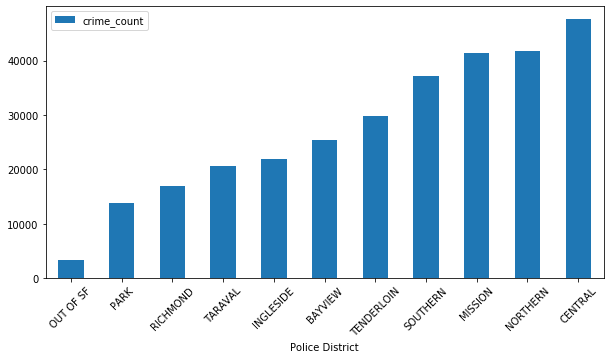

In [20]:
df_police_district_crime_count.plot.bar(x="Police District", y="crime_count", rot=45, figsize=(10, 5))
plt.show()

Let's see police district and number of crimes in each district in the map

In [21]:
# for calculate and set thershold scale
def create_scale_threshold_map(df_, number_):
    threshold_scale=ps.esda.mapclassify.Fisher_Jenks(df_, k = number_).bins.tolist()
    threshold_scale = [int(x) for x in threshold_scale]
    print(threshold_scale)

In [22]:
police_district_map_marker = plot_geo_map_marker([37.7790262, -122.4199061],
                                                 san_francisco_police_district_geo,
                                                 df_police_district_crime_count,
                                                 ["Police District" ,"crime_count"],
                                                 'feature.properties.district',
                                                 df_police_district_crime_count["Latitude"],
                                                 df_police_district_crime_count["Longitude"],
                                                 df_police_district_crime_count["Police District"],
                                                 df_police_district_crime_count["crime_count"],
                                                 [10760, 18119, 25478, 32836, 40195, 48554]
                                                 )


police_district_map_marker


### Total crime in each nighborhood
Lets see all neighborhoods and total crimes on them.

I now want to convert the df_san_francisco_crim data Pandas DataFrame to a GeoPandas GeoDataFrame (a spatial version of the former). The raw crime data comes with lat/long coordinates, which I use these to create Shapely point geometry objects (these are the values in the “geometry” field for each record in a GeoDataFrame). I specify the spatial reference system as ESPG 4326 which represents the standard WGS84 coordinate system

In [23]:
geometry = gpd.GeoSeries(df_san_francisco_crim.apply(lambda x: Point(x['Longitude'], x['Latitude']), 1), crs={'init': 'epsg:4326'})

df_san_francisco_crim = gpd.GeoDataFrame(df_san_francisco_crim, geometry=geometry)

df_san_francisco_crim.head()

C:\Users\Pouria\Anaconda3\envs\capstone_battel_of_neighborhood\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Police District                         Incident Category   Latitude  \
0         Taraval                            Missing Person  37.726950   
1         Mission                           Stolen Property  37.752440   
2        Richmond               Miscellaneous Investigation  37.787112   
3         Central               Miscellaneous Investigation  37.796926   
4         Mission  Offences Against The Family And Children  37.761155   

    Longitude                     geometry  
0 -122.476039  POINT (-122.47604 37.72695)  
1 -122.415172  POINT (-122.41517 37.75244)  
2 -122.440250  POINT (-122.44025 37.78711)  
3 -122.399508  POINT (-122.39951 37.79693)  
4 -122.430574  POINT (-122.43057 37.76116)

Neighborhood areas.

In [24]:
df_san_francisco_neighborhoods = gpd.read_file("geo_export_95ddfcdc-8c12-46e5-9a88-2ab22767f438.shp")
print("Coordination system: ", df_san_francisco_neighborhoods.crs)
df_san_francisco_neighborhoods.head()

Coordination system:  epsg:4326


nbrhood  nid                    sfar_distr  \
0    Alamo Square   6e    District 6 - Central North   
1      Anza Vista   6a    District 6 - Central North   
2  Balboa Terrace   4a  District 4 - Twin Peaks West   
3         Bayview  10a       District 10 - Southeast   
4  Bernal Heights   9a     District 9 - Central East   

                                            geometry  
0  POLYGON ((-122.42948 37.77510, -122.43101 37.7...  
1  POLYGON ((-122.44746 37.77986, -122.44735 37.7...  
2  POLYGON ((-122.46451 37.73221, -122.46504 37.7...  
3  POLYGON ((-122.38759 37.75026, -122.38740 37.7...  
4  POLYGON ((-122.40375 37.74919, -122.40461 37.7...

View the number of crimes in each neighborhood.

In [25]:
df_neighborhoods_crime_counts = gpd.tools.sjoin(
    df_san_francisco_crim.to_crs(
        df_san_francisco_neighborhoods.crs), df_san_francisco_neighborhoods, how="inner", op='intersects').groupby('nbrhood').size()

df_neighborhoods_crime_counts = pd.DataFrame(data=df_neighborhoods_crime_counts.reset_index())

df_neighborhoods_crime_counts.columns=['nbrhood', 'incident_counts']

df_neighborhoods = df_san_francisco_neighborhoods.merge(df_neighborhoods_crime_counts, on='nbrhood')

df_neighborhoods.head()

nbrhood  nid                    sfar_distr  \
0    Alamo Square   6e    District 6 - Central North   
1      Anza Vista   6a    District 6 - Central North   
2  Balboa Terrace   4a  District 4 - Twin Peaks West   
3         Bayview  10a       District 10 - Southeast   
4  Bernal Heights   9a     District 9 - Central East   

                                            geometry  incident_counts  
0  POLYGON ((-122.42948 37.77510, -122.43101 37.7...             2089  
1  POLYGON ((-122.44746 37.77986, -122.44735 37.7...              839  
2  POLYGON ((-122.46451 37.73221, -122.46504 37.7...              162  
3  POLYGON ((-122.38759 37.75026, -122.38740 37.7...             9900  
4  POLYGON ((-122.40375 37.74919, -122.40461 37.7...             4830

In [26]:
df_neighborhoods.shape

(92, 5)

At this point, we find a location for each neighborhood to use on the map as a point.

In [27]:
df_neighborhoods_point_coordination= pd.DataFrame(df_neighborhoods.representative_point())

df_neighborhoods_point_coordination.columns=(['centroid'])
df_neighborhoods_point_coordination['nbrhood'] = df_neighborhoods['nbrhood']
df_neighborhoods_point_coordination['incident_counts'] = df_neighborhoods['incident_counts']


lat = []
lng = []

for index, row in df_neighborhoods_point_coordination.iterrows():
    tmp = str(row[0]).strip('POINT ()').split(' ')
    lng.append(float(tmp[0]))
    lat.append(float(tmp[1]))
    
df_neighborhoods_point_coordination['latitude'] = lat
df_neighborhoods_point_coordination['longitude'] = lng

df_neighborhoods_point_coordination = df_neighborhoods_point_coordination.drop(columns=['centroid'])

df_neighborhoods_point_coordination.head()

nbrhood  incident_counts   latitude   longitude
0    Alamo Square             2089  37.776076 -122.433919
1      Anza Vista              839  37.780611 -122.443255
2  Balboa Terrace              162  37.730649 -122.468267
3         Bayview             9900  37.732391 -122.387170
4  Bernal Heights             4830  37.740230 -122.415885

Lets see all the Nighborhood and number of crimes on them in the map.
So we need latitude and longitude of each neighborhood.

In [28]:
df_neighborhoods_point_coordination.shape

(92, 4)

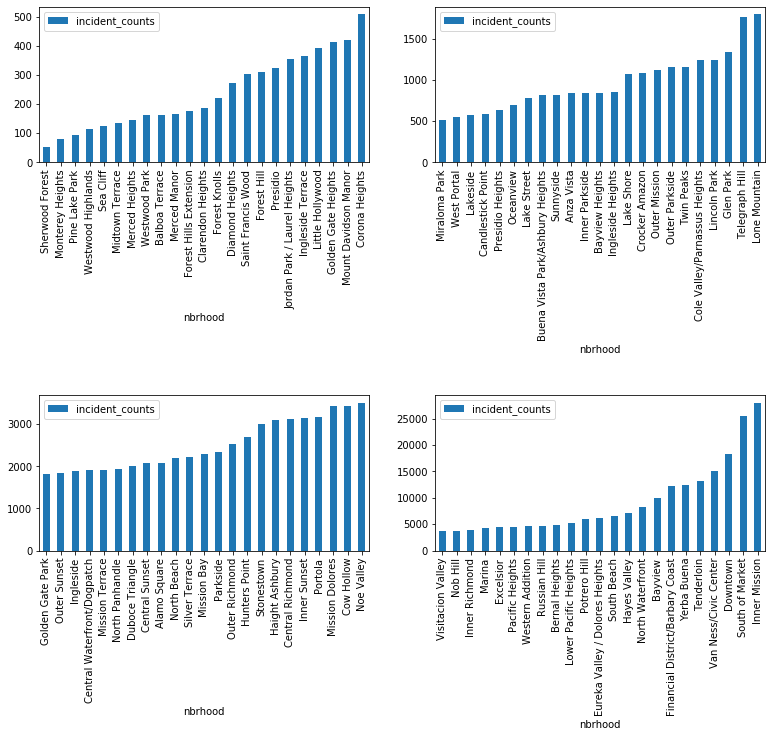

In [29]:
b_ = df_neighborhoods_point_coordination.copy()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
plt.subplots_adjust(hspace = 1.5)

ax11 = axes[0][0]

ax12 = axes[0][1]

ax21 = axes[1][0]

ax22 = axes[1][1]

b_.sort_values(by=["incident_counts"], inplace=True)

part_one = b_.iloc[0:23]
part_two = b_.iloc[23:46]
part_three = b_.iloc[46:69]
part_four = b_.iloc[69:92]


part_one.plot.bar(x="nbrhood", y="incident_counts", ax=ax11, rot=90)
part_two.plot.bar(x="nbrhood", y="incident_counts", ax=ax12, rot=90)
part_three.plot.bar(x="nbrhood", y="incident_counts", ax=ax21, rot=90)
part_four.plot.bar(x="nbrhood", y="incident_counts", ax=ax22, rot=90)
plt.show()


The top 10 safest neighborhood in total.

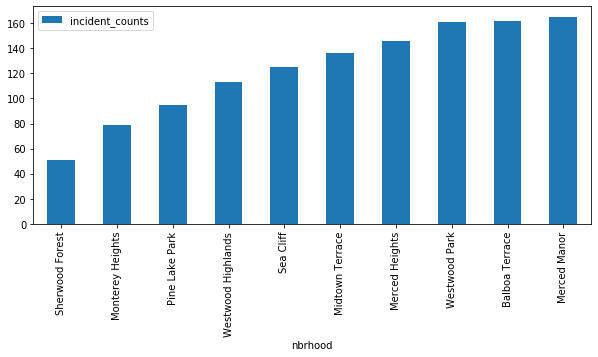

In [30]:
top_10_safest_neighborhoods = b_.iloc[:10]
top_10_safest_neighborhoods.plot.bar(x="nbrhood", y="incident_counts", rot=90, figsize=(10,4))
plt.show()

In [31]:
create_scale_threshold_map(df_neighborhoods_point_coordination["incident_counts"], 6)

bins = list(df_neighborhoods_point_coordination["incident_counts"].quantile([0, 0.25, 0.5, 0.75, 0.85, 1]))
bins = [int(x) for x in bins]
print(bins)

[1345, 3817, 8210, 13252, 18294, 28065]
[51, 513, 1805, 3559, 4956, 28065]


In [32]:
neighborhoods_map_marker = plot_geo_map_marker([37.7790262, -122.4199061],
                                                 df_neighborhoods.to_json(),
                                                 df_neighborhoods,
                                                 ["nbrhood", "incident_counts"],
                                                 'feature.properties.nbrhood',
                                                 df_neighborhoods_point_coordination["latitude"], 
                                                 df_neighborhoods_point_coordination["longitude"], 
                                                 df_neighborhoods_point_coordination["nbrhood"],
                                                 df_neighborhoods_point_coordination["incident_counts"],
                                                 [51, 513, 1805, 3559, 4956, 29065]
                                                )



neighborhoods_map_marker

In [33]:
police_district_neighborhood_map_marker = plot_geo_map_marker([37.7790262, -122.4199061],
                                                 san_francisco_police_district_geo,
                                                 df_police_district_crime_count,
                                                 ["Police District" ,"crime_count"],
                                                 'feature.properties.district',
                                                 df_neighborhoods_point_coordination["latitude"], 
                                                 df_neighborhoods_point_coordination["longitude"], 
                                                 df_neighborhoods_point_coordination["nbrhood"],
                                                 df_neighborhoods_point_coordination["incident_counts"],
                                                 [10760, 18119, 25478, 32836, 40195, 48554]
                                                 )


police_district_neighborhood_map_marker

Show the neighborhoods in our two safest districts.
Area of the neighborhood may be locate in two or more districts. 

In [34]:
gpd_police_district = gpd.read_file("Current Police Districts.geojson")
gpd_police_district = gpd_police_district[["district", "geometry"]]
gpd_police_district = gpd_police_district[(gpd_police_district["district"] == "PARK") | (gpd_police_district["district"] == "RICHMOND")]

gpd_neighborhood = df_neighborhoods[["nbrhood", "geometry", "incident_counts"]]

districts_with_neighborhoods = gpd.sjoin(gpd_neighborhood, gpd_police_district, how="inner", op="intersects")
districts_with_neighborhoods.head()



nbrhood  \
0                      Alamo Square   
1                        Anza Vista   
5  Buena Vista Park/Ashbury Heights   
8                 Clarendon Heights   
9                    Corona Heights   

                                            geometry  incident_counts  \
0  POLYGON ((-122.42948 37.77510, -122.43101 37.7...             2089   
1  POLYGON ((-122.44746 37.77986, -122.44735 37.7...              839   
5  POLYGON ((-122.43562 37.76733, -122.43565 37.7...              815   
8  POLYGON ((-122.44635 37.76032, -122.44643 37.7...              186   
9  POLYGON ((-122.43576 37.76723, -122.43576 37.7...              509   

   index_right district  
0            6     PARK  
1            6     PARK  
5            6     PARK  
8            6     PARK  
9            6     PARK

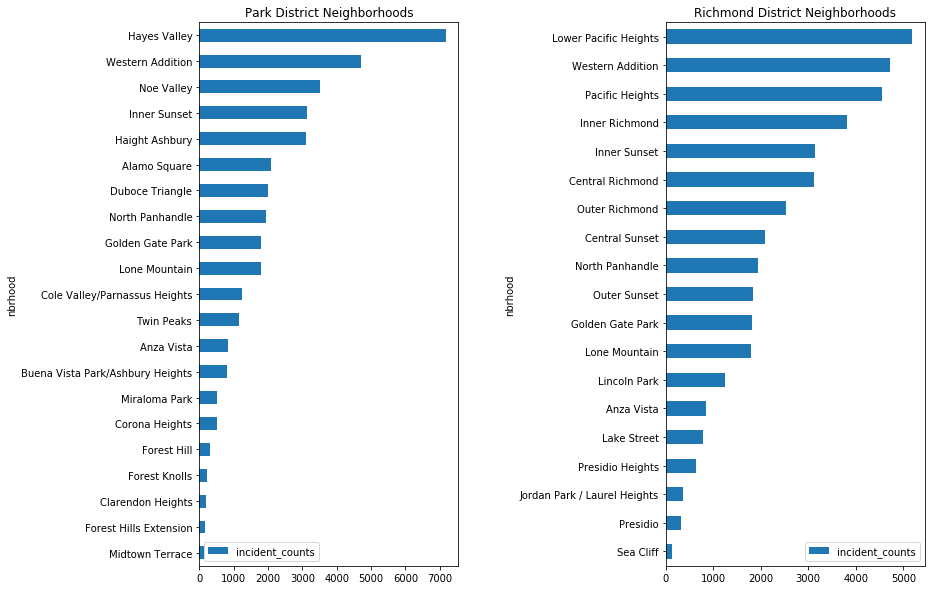

In [35]:
districts_with_neighborhoods_ = districts_with_neighborhoods.set_index("district")

district_park = districts_with_neighborhoods_.loc["PARK"]
district_richmond = districts_with_neighborhoods_.loc["RICHMOND"]

# convert to data frame
district_richmond = pd.DataFrame(district_richmond)
district_park = pd.DataFrame(district_park)

# ploting
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=(13,10))
plt.subplots_adjust(wspace = 0.8)

axes1.set_title("Park District Neighborhoods")
axes2.set_title("Richmond District Neighborhoods")

district_park.sort_values(by=["incident_counts"], inplace=True)
district_richmond.sort_values(by=["incident_counts"], inplace=True)


district_park.plot.barh(x="nbrhood", y="incident_counts", ax=axes1,)
district_richmond.plot.barh(x="nbrhood", y="incident_counts", ax=axes2,)

plt.show()

In [36]:
list_of_neighborhood_names = list(set(districts_with_neighborhoods["nbrhood"].tolist()))

df_for_map = df_neighborhoods_point_coordination.set_index("nbrhood")
df_for_map = df_for_map.loc[list_of_neighborhood_names]
df_for_map =df_for_map.reset_index()

map_of_safe_district_safe_neighborhood = plot_geo_map_marker([37.7790262, -122.4199061],
                                                 san_francisco_police_district_geo,
                                                 df_police_district_crime_count,
                                                 ["Police District" ,"crime_count"],
                                                 'feature.properties.district',
                                                 df_for_map["latitude"], 
                                                 df_for_map["longitude"], 
                                                 df_for_map["nbrhood"],
                                                 df_for_map["incident_counts"],
                                                 [10760, 18119, 25478, 32836, 40195, 48554]
                                                 )


map_of_safe_district_safe_neighborhood

#### let find the venus in this nighborhoods

In [126]:
# Use your Id and Secret
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180927' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Get Nearby Venuse For Each One Of The Neighborhoods

In [38]:
san_francisco_neighborhoods_venues = getNearbyVenues(names=df_neighborhoods_point_coordination['nbrhood'],
                                                       latitudes=df_neighborhoods_point_coordination['latitude'],
                                                       longitudes=df_neighborhoods_point_coordination['longitude'])

Alamo Square
Anza Vista
Balboa Terrace
Bayview
Bernal Heights
Buena Vista Park/Ashbury Heights
Central Richmond
Central Sunset
Clarendon Heights
Corona Heights
Cow Hollow
Crocker Amazon
Diamond Heights
Downtown
Duboce Triangle
Eureka Valley / Dolores Heights
Excelsior
Financial District/Barbary Coast
Yerba Buena
Forest Hill
Forest Hills Extension
Forest Knolls
Glen Park
Golden Gate Heights
Golden Gate Park
Haight Ashbury
Hayes Valley
Hunters Point
Ingleside
Ingleside Heights
Ingleside Terrace
Inner Mission
Inner Parkside
Inner Richmond
Inner Sunset
Jordan Park / Laurel Heights
Lake Street
Monterey Heights
Lake Shore
Lakeside
Lone Mountain
Lower Pacific Heights
Marina
Merced Heights
Merced Manor
Midtown Terrace
South Beach
Miraloma Park
Mission Bay
Mission Dolores
Mission Terrace
Mount Davidson Manor
Noe Valley
North Beach
North Panhandle
North Waterfront
Oceanview
Outer Mission
Outer Parkside
Outer Richmond
Outer Sunset
Pacific Heights
Parkside
Cole Valley/Parnassus Heights
Pine Lake P

In [39]:
san_francisco_neighborhoods_venues.shape

(3344, 7)

#### Analyze Each Neighborhood

In [40]:
# one hot encoding
san_francisco_onehot = pd.get_dummies(san_francisco_neighborhoods_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
san_francisco_onehot['Neighborhood'] = san_francisco_neighborhoods_venues['Neighborhood'] 

# move neighborhood column to the first column
list_of_col = list(san_francisco_onehot.columns)
neighborhood_index = list_of_col.index("Neighborhood")

fixed_columns = [san_francisco_onehot.columns[neighborhood_index]] + list(san_francisco_onehot.columns[:neighborhood_index]) + list(san_francisco_onehot.columns[neighborhood_index+1:])
san_francisco_onehot = san_francisco_onehot[fixed_columns]

san_francisco_onehot.head()

Neighborhood  ATM  Acai House  Accessories Store  Adult Boutique  \
0  Alamo Square    0           0                  0               0   
1  Alamo Square    0           0                  0               0   
2  Alamo Square    0           0                  0               0   
3  Alamo Square    0           0                  0               0   
4  Alamo Square    0           0                  0               0   

   African Restaurant  Alternative Healer  American Restaurant  Antique Shop  \
0                   0                   0                    0             0   
1                   0                   0                    0             0   
2                   0                   0                    0             0   
3                   0                   0                    0             0   
4                   0                   0                    0             0   

   Arcade  Arepa Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0       0                 0            0           0                    0   
1       0                 0            0           0                    0   
2       0                 0            0           0                    0   
3       0                 0            0           0                    0   
4       0                 0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Automotive Shop  BBQ Joint  \
0                 0                   0                0          0   
1                 0                   0                0          0   
2                 0                   0                0          0   
3                 0                   0                0          0   
4                 0                   0                0          0   

   Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0           0           0       0     0    0               0   
1           0           0       0     0    0               0   
2           0           0       0     0    0               0   
3           0           0       0     0    0               0   
4           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                0         0            0           0              0   
4                0         0            0           0              0   

   Bike Rental / Bike Share  Bike Shop  Board Shop  Boat or Ferry  Bookstore  \
0                         0          0           0              0          0   
1                         0          0           0              0          0   
2                         0          0           0              0          0   
3                         0          0           0              0          0   
4                         0          0           0              0          0   

   Boutique  Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  \
0         0              0           0                     0               0   
1         0              0           0                     0               0   
2         0              0           0                     0               0   
3         0              0           0                     0               0   
4         0              0           0                     0               0   

   Brewery  Bubb

In [41]:
san_francisco_onehot.shape

(3344, 340)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [42]:
san_francisco_grouped_venus = san_francisco_onehot.groupby('Neighborhood').mean().reset_index()
san_francisco_grouped_venus

Neighborhood    ATM  Acai House  Accessories Store  \
0                       Alamo Square  0.000        0.00           0.000000   
1                         Anza Vista  0.000        0.00           0.000000   
2                     Balboa Terrace  0.000        0.00           0.000000   
3                            Bayview  0.000        0.00           0.000000   
4                    Bayview Heights  0.000        0.00           0.000000   
5                     Bernal Heights  0.000        0.00           0.000000   
6   Buena Vista Park/Ashbury Heights  0.000        0.00           0.019608   
7                  Candlestick Point  0.000        0.00           0.000000   
8                   Central Richmond  0.000        0.00           0.000000   
9                     Central Sunset  0.000        0.00           0.000000   
10       Central Waterfront/Dogpatch  0.000        0.00           0.017241   
11                 Clarendon Heights  0.000        0.00           0.000000   
12     Cole Valley/Parnassus Heights  0.000        0.00           0.000000   
13                    Corona Heights  0.000        0.00           0.000000   
14                        Cow Hollow  0.000        0.00           0.010204   
15                    Crocker Amazon  0.000        0.00           0.000000   
16                   Diamond Heights  0.000        0.00           0.000000   
17                          Downtown  0.000        0.00           0.000000   
18                   Duboce Triangle  0.000        0.00           0.000000   
19   Eureka Valley / Dolores Heights  0.000        0.00           0.000000   
20                         Excelsior  0.000        0.00           0.000000   
21  Financial District/Barbary Coast  0.000        0.01           0.000000   
22                       Forest Hill  0.000        0.00           0.000000   
23            Forest Hills Extension  0.000        0.00           0.000000   
24                     Forest Knolls  0.000        0.00           0.000000   
25                         Glen Park  0.000        0.00           0.000000   
26               Golden Gate Heights  0.000        0.00           0.000000   
27                  Golden Gate Park  0.000        0.00           0.000000   
28                    Haight Ashbury  0.000        0.00           0.020000   
29                      Hayes Valley  0.000        0.00           0.000000   
30                     Hunters Point  0.000        0.00           0.000000   
31                         Ingleside  0.000        0.00           0.000000   
32                 Ingleside Heights  0.000        0.00           0.000000   
33                 Ingleside Terrace  0.000        0.00           0.000000   
34                     Inner Mission  0.000        0.00           0.000000   
35                    Inner Parkside  0.000        0.00           0.000000   
36                    Inner Richmond  0.000        0.00           0.000000   
37                      Inner Sunset  0.000        0.00           0.000000   
38      Jordan Park / Laurel Heights  0.000        0.00           0.000000   
39                        Lake Shore  0.000        0.00           0.000000   
40                       Lake Street  0.000        0.00           0.000000   
41                          Lakeside  0.000        0.00           0.020833   
42                      Lincoln Park  0.000        0.00           0.000000   
43                  Little Hollywood  0.000        0.00           0.000000   
44                     Lone Mountain  0.000        0.00           0.000000   
45             Lower Pacific Heights  0.000        0.00           0.000000   
46                            Marina  0.000        0.00           0.000000   
47                    Merced Heights  0.000        0.00           0.000000   
48                      Merced Manor  0.000        0.00           0.000000   
49                   Midtown Terrace  0.000        0.00           0.000000   
50                     Miraloma Park  0.000   

In [43]:
san_francisco_grouped_total = san_francisco_onehot.groupby('Neighborhood').sum().reset_index()
san_francisco_grouped_total

Neighborhood  ATM  Acai House  Accessories Store  \
0                       Alamo Square    0           0                  0   
1                         Anza Vista    0           0                  0   
2                     Balboa Terrace    0           0                  0   
3                            Bayview    0           0                  0   
4                    Bayview Heights    0           0                  0   
5                     Bernal Heights    0           0                  0   
6   Buena Vista Park/Ashbury Heights    0           0                  1   
7                  Candlestick Point    0           0                  0   
8                   Central Richmond    0           0                  0   
9                     Central Sunset    0           0                  0   
10       Central Waterfront/Dogpatch    0           0                  1   
11                 Clarendon Heights    0           0                  0   
12     Cole Valley/Parnassus Heights    0           0                  0   
13                    Corona Heights    0           0                  0   
14                        Cow Hollow    0           0                  1   
15                    Crocker Amazon    0           0                  0   
16                   Diamond Heights    0           0                  0   
17                          Downtown    0           0                  0   
18                   Duboce Triangle    0           0                  0   
19   Eureka Valley / Dolores Heights    0           0                  0   
20                         Excelsior    0           0                  0   
21  Financial District/Barbary Coast    0           1                  0   
22                       Forest Hill    0           0                  0   
23            Forest Hills Extension    0           0                  0   
24                     Forest Knolls    0           0                  0   
25                         Glen Park    0           0                  0   
26               Golden Gate Heights    0           0                  0   
27                  Golden Gate Park    0           0                  0   
28                    Haight Ashbury    0           0                  2   
29                      Hayes Valley    0           0                  0   
30                     Hunters Point    0           0                  0   
31                         Ingleside    0           0                  0   
32                 Ingleside Heights    0           0                  0   
33                 Ingleside Terrace    0           0                  0   
34                     Inner Mission    0           0                  0   
35                    Inner Parkside    0           0                  0   
36                    Inner Richmond    0           0                  0   
37                      Inner Sunset    0           0                  0   
38      Jordan Park / Laurel Heights    0           0                  0   
39                        Lake Shore    0           0                  0   
40                       Lake Street    0           0                  0   
41                          Lakeside    0           0                  1   
42                      Lincoln Park    0           0                  0   
43                  Little Hollywood    0           0                  0   
44                     Lone Mountain    0           0                  0   
45             Lower Pacific Heights    0           0                  0   
46                            Marina    0           0                  0   
47                    Merced Heights    0           0                  0   
48                      Merced Manor    0           0                  0   
49                   Midtown Terrace    0           0                  0   
50                     Miraloma Park    0           0                  0   
51                       Mission Bay    0           0                  0

#### reate the new dataframe and display the top 10 venues for each neighborhood.

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = san_francisco_grouped_venus['Neighborhood']

for ind in np.arange(san_francisco_grouped_venus.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(san_francisco_grouped_venus.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood            1st Most Common Venue 2nd Most Common Venue  \
0     Alamo Square                              Bar             BBQ Joint   
1       Anza Vista                             Café         Grocery Store   
2   Balboa Terrace               Light Rail Station              Pharmacy   
3          Bayview  Southern / Soul Food Restaurant    Light Rail Station   
4  Bayview Heights                   Breakfast Spot          Burger Joint   

       3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
0       Ethiopian Restaurant      Sushi Restaurant               Gift Shop   
1         Mexican Restaurant        Shop & Service           Big Box Store   
2                        Gym            Comic Shop              Playground   
3                       Café                  Park  Thrift / Vintage Store   
4  Latin American Restaurant                  Park             Yoga Studio   

             6th Most Common Venue     7th Most Common Venue  \
0                     Cocktail Bar  Mediterranean Restaurant   
1  Southern / Soul Food Restaurant               Coffee Shop   
2                           Bakery                      Bank   
3                          Theater                 BBQ Joint   
4                         Fountain         Fondue Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                   Park              Wine Bar       Spiritual Center  
1                 Tunnel        Sandwich Place      Electronics Store  
2  Vietnamese Restaurant              Fountain                   Park  
3                    Gym   Dumpling Restaurant          Grocery Store  
4                   Food     Food & Drink Shop             Food Stand

#### Cluster Neighborhoods

In [45]:
# set number of clusters
kclusters = 5

san_francisco_grouped_clustering = san_francisco_grouped_venus.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(san_francisco_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# Create new DataFrame

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

san_francisco_merged = df_neighborhoods_point_coordination

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
san_francisco_merged = san_francisco_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='nbrhood')

san_francisco_merged.head() # check the last columns!

nbrhood  incident_counts   latitude   longitude  Cluster Labels  \
0    Alamo Square             2089  37.776076 -122.433919               2   
1      Anza Vista              839  37.780611 -122.443255               2   
2  Balboa Terrace              162  37.730649 -122.468267               2   
3         Bayview             9900  37.732391 -122.387170               2   
4  Bernal Heights             4830  37.740230 -122.415885               2   

             1st Most Common Venue 2nd Most Common Venue  \
0                              Bar             BBQ Joint   
1                             Café         Grocery Store   
2               Light Rail Station              Pharmacy   
3  Southern / Soul Food Restaurant    Light Rail Station   
4                      Coffee Shop            Playground   

  3rd Most Common Venue 4th Most Common Venue   5th Most Common Venue  \
0  Ethiopian Restaurant      Sushi Restaurant               Gift Shop   
1    Mexican Restaurant        Shop & Service           Big Box Store   
2                   Gym            Comic Shop              Playground   
3                  Café                  Park  Thrift / Vintage Store   
4                Bakery    Italian Restaurant                    Park   

             6th Most Common Venue     7th Most Common Venue  \
0                     Cocktail Bar  Mediterranean Restaurant   
1  Southern / Soul Food Restaurant               Coffee Shop   
2                           Bakery                      Bank   
3                          Theater                 BBQ Joint   
4                            Trail              Gourmet Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                   Park              Wine Bar       Spiritual Center  
1                 Tunnel        Sandwich Place      Electronics Store  
2  Vietnamese Restaurant              Fountain                   Park  
3                    Gym   Dumpling Restaurant          Grocery Store  
4            Yoga Studio         Grocery Store           Cocktail Bar

#### Visualize the resulting clusters

In [46]:
# create map
map_clusters = folium.Map(location=[37.7790262, -122.4199061], zoom_start=12, width="100%", height="100%")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(san_francisco_merged['latitude'], san_francisco_merged['longitude'], san_francisco_merged['nbrhood'], san_francisco_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 0 - red 

In [47]:
map_clusters = folium.Map(location=[37.7790262, -122.4199061], zoom_start=12, width="100%", height="100%")

                                                 
# add chloropleth layer
map_clusters.choropleth(
        df_neighborhoods.to_json(),
        df_neighborhoods,
        ["nbrhood", "incident_counts"],
        'feature.properties.nbrhood',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        threshold_scale= [51, 513, 1805, 3559, 4956, 29065],
        line_opacity=0.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(san_francisco_merged['latitude'], san_francisco_merged['longitude'], san_francisco_merged['nbrhood'], san_francisco_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [48]:
san_francisco_grouped_total.set_index("Neighborhood", inplace=True)

In [49]:
cluster_0 = san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 0, san_francisco_merged.columns[[0] + list(range(5, san_francisco_merged.shape[1]))]]
print(cluster_0.shape)
cluster_0

(12, 11)


nbrhood 1st Most Common Venue 2nd Most Common Venue  \
19        Forest Hill          Tennis Court   Japanese Restaurant   
24   Golden Gate Park                  Park                 Track   
30  Ingleside Terrace            Playground    Chinese Restaurant   
37   Monterey Heights              Fountain              Bus Line   
38         Lake Shore                  Lake           Golf Course   
43     Merced Heights    Light Rail Station             Racetrack   
44       Merced Manor                   Gym                  Park   
47      Miraloma Park                  Park                  Tree   
64     Pine Lake Park                  Park        Sandwich Place   
65            Portola     Recreation Center                  Lake   
88  Candlestick Point      Football Stadium            Playground   
89    Bayview Heights        Breakfast Spot          Burger Joint   

        3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19          French Restaurant     Hotpot Restaurant            Playground   
24                       Lake             Disc Golf              Bus Stop   
30               Dessert Shop   Japanese Restaurant                  Park   
37                       Park           Yoga Studio           Flower Shop   
38        American Restaurant                  Park           Yoga Studio   
43                       Park            Playground          Liquor Store   
44                 Restaurant            Food Truck          Tennis Court   
47                   Bus Line   Monument / Landmark            Playground   
64        Hawaiian Restaurant                   Gym               Dog Run   
65                Music Venue                  Park            Playground   
88               Soccer Field            Campground   American Restaurant   
89  Latin American Restaurant                  Park           Yoga Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
19                  Park            Food Stand   Filipino Restaurant   
24           Yoga Studio              Fountain     Fondue Restaurant   
30     Convenience Store             Pool Hall            Comic Shop   
37     Fondue Restaurant                  Food     Food & Drink Shop   
38              Fountain           Flower Shop     Fondue Restaurant   
43            Food Truck   Filipino Restaurant           Flower Shop   
44                Bakery           Art Gallery             Pet Store   
47           Yoga Studio            Food Truck           Flower Shop   
64      Asian Restaurant            Food Truck           Flower Shop   
65           Yoga Studio      Football Stadium           Flower Shop   
88               Stadium                  Park     Food & Drink Shop   
89              Fountain     Fondue Restaurant                  Food   

   9th Most Common Venue 10th Most Common Venue  
19           Flower Shop      Fondue Restaurant  
24                  Food      Food & Drink Shop  
30                   Gym            Yoga Studio  
37            Food Stand             Food Truck  
38                  Food      Food & Drink Shop  
43     Fondue Restaurant                   Food  
44            Playground     Weight Loss Center  
47     Fondue Restaurant                   Food  
64     Fondue Restaurant                   Food  
65     Fondue Restaurant                   Food  
88           Flower Shop      Fondue Restaurant  
89     Food & Drink Shop             Food Stand

#### Cluster 1 - purpel

In [50]:
cluster_1 = san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 1, san_francisco_merged.columns[[0] + list(range(5, san_francisco_merged.shape[1]))]]
print(cluster_1.shape)
cluster_1

(8, 11)


nbrhood 1st Most Common Venue 2nd Most Common Venue  \
8     Clarendon Heights                 Trail                Garden   
21        Forest Knolls                 Trail                  Park   
23  Golden Gate Heights                 Trail                  Park   
45      Midtown Terrace        Scenic Lookout                 Trail   
71            Sea Cliff                 Trail           Golf Course   
77           Twin Peaks                 Trail        Scenic Lookout   
79    Visitacion Valley                 Trail                  Pool   
85      Sherwood Forest                 Trail                  Tree   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
8                   Park              Wine Bar     Convenience Store   
21                Garden              Bus Stop              Mountain   
23            Playground        Scenic Lookout          Tennis Court   
45   Monument / Landmark            Playground            Food Stand   
71                 Beach              Tea Room        Scenic Lookout   
77                  Hill             Reservoir      Department Store   
79           Coffee Shop                  Park    Chinese Restaurant   
85              Bus Stop                  Park   Monument / Landmark   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
8                   Road           Tailor Shop           Art Gallery   
21      Football Stadium           Flower Shop     Fondue Restaurant   
23  Fast Food Restaurant   Filipino Restaurant           Flower Shop   
45  Fast Food Restaurant   Filipino Restaurant           Flower Shop   
71            Food Truck   Filipino Restaurant           Flower Shop   
77         Design Studio          Dance Studio  Fast Food Restaurant   
79                Garden   Fried Chicken Joint  Fast Food Restaurant   
85            Food Truck   Filipino Restaurant           Flower Shop   

   9th Most Common Venue 10th Most Common Venue  
8         Scenic Lookout             Playground  
21                  Food      Food & Drink Shop  
23     Fondue Restaurant                   Food  
45     Fondue Restaurant                   Food  
71     Fondue Restaurant                   Food  
77   Filipino Restaurant            Flower Shop  
79   Filipino Restaurant            Flower Shop  
85     Fondue Restaurant                   Food

#### Cluster 2 - blue

In [51]:
cluster_2 = san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 2, san_francisco_merged.columns[[0] + list(range(5, san_francisco_merged.shape[1]))]]
print(cluster_2.shape)
cluster_2

(70, 11)


nbrhood            1st Most Common Venue  \
0                       Alamo Square                              Bar   
1                         Anza Vista                             Café   
2                     Balboa Terrace               Light Rail Station   
3                            Bayview  Southern / Soul Food Restaurant   
4                     Bernal Heights                      Coffee Shop   
5   Buena Vista Park/Ashbury Heights                             Park   
6                   Central Richmond                 Sushi Restaurant   
7                     Central Sunset               Chinese Restaurant   
9                     Corona Heights                          Gay Bar   
10                        Cow Hollow                   Cosmetics Shop   
11                    Crocker Amazon                  Bubble Tea Shop   
12                   Diamond Heights                            Trail   
13                          Downtown                            Hotel   
14                   Duboce Triangle                      Coffee Shop   
15   Eureka Valley / Dolores Heights                          Gay Bar   
17  Financial District/Barbary Coast                      Coffee Shop   
18                       Yerba Buena                      Coffee Shop   
20            Forest Hills Extension                         Bus Stop   
22                         Glen Park                             Park   
25                    Haight Ashbury                         Boutique   
26                      Hayes Valley                         Wine Bar   
27                     Hunters Point                     Home Service   
28                         Ingleside                  Bubble Tea Shop   
29                 Ingleside Heights                      Yoga Studio   
31                     Inner Mission                             Café   
32                    Inner Parkside               Chinese Restaurant   
33                    Inner Richmond                Korean Restaurant   
34                      Inner Sunset                      Yoga Studio   
35      Jordan Park / Laurel Heights                      Coffee Shop   
36                       Lake Street                             Café   
39                          Lakeside                   Clothing Store   
40                     Lone Mountain                             Café   
41             Lower Pacific Heights                           Bakery   
42                            Marina             Gym / Fitness Center   
46                       South Beach                             Park   
48                       Mission Bay                       Food Truck   
49                   Mission Dolores               Mexican Restaurant   
50                   Mission Terrace                   Sandwich Place   
51              Mount Davidson Manor               Chinese Restaurant   
52                        Noe Valley                      Coffee Shop   
53                       North Beach                             Café   
54                   North Panhandle                              Bar   
55                  North Waterfront                            Trail   
56                         Oceanview               Light Rail Station   
57                     Outer Mission                           Bakery   
58                    Outer Parkside                      Coffee Shop   
59                    Outer Richmond               Chinese Restaurant   
60                      Outer Sunset                      Art Gallery   
61                   Pacific Heights                   Cosmetics Shop   
62                          Parkside               Chinese Restaurant   
63     Cole Valley/Parnassus Heights                         Wine Bar   
66                      Potrero Hill                             Park   
67                          Presidio                           Museum   
68                  Presidio Heights              American Restaurant   
69            

#### Cluster 3 - green

In [54]:
cluster_3 = san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 3, san_francisco_merged.columns[[0] + list(range(5, san_francisco_merged.shape[1]))]]
print(cluster_3.shape)
cluster_3

(1, 11)


nbrhood 1st Most Common Venue 2nd Most Common Venue  \
72  Silver Terrace         Grocery Store          Soccer Field   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
72    Athletics & Sports                  Park           Yoga Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
72            Food Truck           Flower Shop     Fondue Restaurant   

   9th Most Common Venue 10th Most Common Venue  
72                  Food      Food & Drink Shop

#### Cluster 4 - Orange

In [55]:
cluster_4 = san_francisco_merged.loc[san_francisco_merged['Cluster Labels'] == 4, san_francisco_merged.columns[[0] + list(range(5, san_francisco_merged.shape[1]))]]
print(cluster_4.shape)
cluster_4

(1, 11)


nbrhood 1st Most Common Venue 2nd Most Common Venue  \
16  Excelsior     Convenience Store                  Lake   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
16        Scenic Lookout           Yoga Studio            Food Truck   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
16  Fast Food Restaurant   Filipino Restaurant           Flower Shop   

   9th Most Common Venue 10th Most Common Venue  
16     Fondue Restaurant                   Food

<Figure size 1440x720 with 0 Axes>

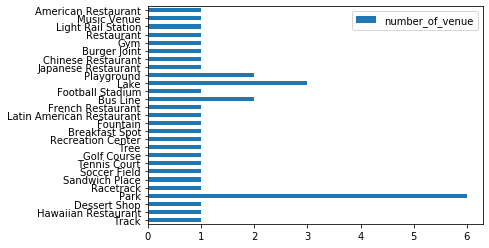

In [119]:
plot_number_of_venue(cluster_0)

<Figure size 1440x720 with 0 Axes>

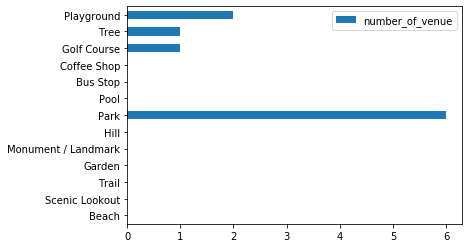

In [120]:
plot_number_of_venue(cluster_1)

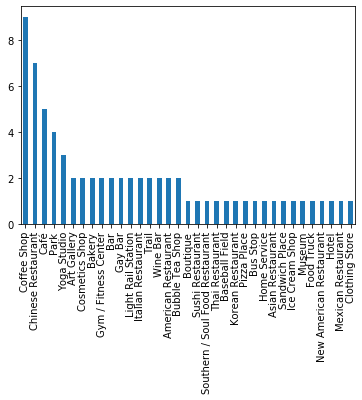

In [122]:
# first commone venue in cluster 2
cluster_2["1st Most Common Venue"].value_counts().T.plot.bar()

<Figure size 1440x720 with 0 Axes>

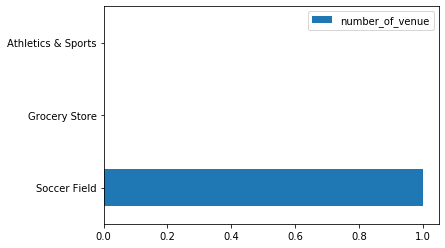

In [123]:
plot_number_of_venue(cluster_3)

<Figure size 1440x720 with 0 Axes>

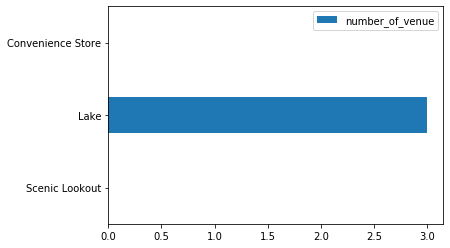

In [124]:
plot_number_of_venue(cluster_4)

## Results and Discussion <a name="results"></a>

We divided our data into five clusters, the number zero is marked in red, with the park, playground, and gym being the most common venue, followed by restaurants as second place.

In the number one cluster, which is marked in purple, trails, parks and gardens are the most common venue.

number two, which is marked in blue, has the most coffee shops, restaurants, etc.

It has the number three marked in green, has the most Grocery store, soccer field. 

Number four marked in orange and has, Convenience Store, lake and scenic lookout.

Based on our analysis of the data obtained, most restaurants, coffee shops, etc. are at the top right and bottom of the map, which continues to the center of the map. (Blue based on cluster number 2)

In the center of the map, the number of these cases decreases. Since our priority was first to select the safest area, we first select the Park district. After this district, we can consider the Richmond district.
In the park district, Midtown terrace has the lowest crime rate, which is marked in blue number one cluster. This cluster mostly includes trailers, parks and playgrounds.

After that, we can name Forest Hills Extension neighborhood in cluster number 2 and finally Clarendon Heights neighborhood in cluster number one.


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the safest areas of San Francisco and then the safest neighborhood in that area with a small number of Asian or Japanese restaurants. To establish a Japanese restaurant.
Using clustering, we were able to identify areas where the number of restaurants is low and introduce three desirable neighborhoods in the safest area.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.